Here is our training data, the XOR function. Note the first column, of all ones, will be to compute biases.

In [10]:
import numpy as np
nonlin = 'sigmoid'
X = np.array([(1, -1, -1),(1, -1, 1),(1, 1, -1),(1, 1, 1)])
Y = np.array([(1, 0), (0, 1),(0, 1),(1, 0)])



And here are our starting weight matrices. WHI contains the weights projecting from the input layer to the hidden layer, and WOH contains the weights projecting from the hidden layer to the output layer. Note that WHI contains a first "phantom" row of all zeros; this is a little hack to for the bias computation.

In [11]:
WHI = np.array([(0, 0, 0),(-0.0130107, 0.0018050, 0.0170633), (0.0420667, 0.0069242, 0.0421364),(-0.0082391, -0.0285141, 0.0302499)])
WOH = np.array([(0.0338, 0.0046, -0.0072, -0.0052),(0.0264, 0.0123, 0.0093, -0.0101)])
print("WHI: ")
print(WHI)
print("WOH: ")
print(WOH)

WHI: 
[[ 0.         0.         0.       ]
 [-0.0130107  0.001805   0.0170633]
 [ 0.0420667  0.0069242  0.0421364]
 [-0.0082391 -0.0285141  0.0302499]]
WOH: 
[[ 0.0338  0.0046 -0.0072 -0.0052]
 [ 0.0264  0.0123  0.0093 -0.0101]]


Now we can start on the forward pass. In each case we will multiply the projection matrix by the input, with training instances in the columns, then applying the nonlinearity. We handle the bias by creating one extra hidden unit and resetting it to "1" after the activations have been computed. This requires extra computation, but in a realistically sized net it would be a tiny waste. First we'll define the nonlinearity. For now we are using the sigmoid function, but we will allow the user to specify the nonlinearity so we can use other choices later.

To allow for arbitrary numbers of layers we'll pass the weight vectors in as a list, and return a list of activations (which we'll need later for backprop).

Here's the sigmoid to produce the first hidden output

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def scalar_rectifier(x):
    if x > 0:
        return x;
    return x * .01

def rectifier(x):
    return np.vectorize(scalar_rectifier)(x)
    
    
    
def forward(x, WEIGHTS, nl):
    #note that we transpose x to put the training examples in columns here
    inAct = np.transpose(x);
    activations=[]
    for i in range(0, len(WEIGHTS)):
        W = WEIGHTS[i]
        NET = np.dot(W, inAct)
        if nl == 'sigmoid':
            act = sigmoid(NET);
        elif nl == 'tanh':
            act = np.tanh(NET);
        elif nl == 'relu':
            act = rectifier(NET);
        else:
            raise Exception('unsupported nonlinearity')
        if i != len(WEIGHTS) - 1:
            act[0,:] = 1
        activations = activations + [act]
        inAct = act
    return np.array(activations)

def compute_error(A, Y):
    last = len(A) - 1
    err = Y - A[last]
    sqerr = err * err;
    return np.sum(sqerr)
    

WEIGHTS = [WHI, WOH]
activations = forward(X, WEIGHTS, 'sigmoid')
print(activations)
err = compute_error(activations, np.transpose(Y))
print("Error: " + str(err))

[array([[1.        , 1.        , 1.        , 1.        ],
       [0.49203092, 0.5005619 , 0.49293322, 0.5014644 ],
       [0.49825153, 0.51931012, 0.50171362, 0.52276607],
       [0.4975063 , 0.51262854, 0.48325549, 0.49837418]])
 array([[0.50747167, 0.50742393, 0.507485  , 0.50743727],
       [0.50801454, 0.50805154, 0.50806134, 0.50809833]])]
Error: 2.000481886223878


That was the easy part. Now let's do the hard part (backprop).

In [13]:
def sigderiv(x):
    return (x * (1-x))
def tanhderiv(x):
    return(1 - (x*x))
def recderiv_scalar(x):
    if x > 0:
        return 1
    return 0.01

def recderiv(x):
    return np.vectorize(recderiv_scalar)(x)

#The derivative of the cost function with respect to the output,
# dE / dO
def CostDeriv(gold, predicted):
    return -(gold - predicted)
    
    
def nlderiv(x, nl):
    if nl == 'sigmoid':
        return sigderiv(x)
    elif nl == 'tanh':
        return tanhderiv(x)
    elif nl == 'relu':
        return recderiv(x)
    else:
        raise Exception('unsupported nonlin')
#A = activatitions from all layers
#Y = targets
#nl = nonlinearity type
#returns a list of update weights
def backprop(X, A, Y, W, nl, rate):
    #First compute the gradients
    #This is the derivative of the nonlinearity function.
    updates = []
    nlgrad = np.ones((1))
    out_idx = len(A) - 1
    gradients = []
    #derivative of output w.r.t. net (z)
    nlgrad = nlderiv(A[out_idx], nl)
    #derivative of error w.r.t. output
    dedo = CostDeriv(np.transpose(Y), A[out_idx])
    delta_k = nlgrad * dedo
    gradients = [delta_k]
    delta_prev = delta_k
    for i in range(out_idx - 1, -1, -1):
        #print("iter " + str(i))
        #Compute the weighted gradient from prev layer
        wg = np.transpose(W[i + 1]).dot(delta_prev)
        deriv = nlderiv(A[i], nl)
        delta_new = deriv * wg
        delta_prev = delta_new
        gradients = [delta_new] + gradients
    #Now compute the updates
    #for g in gradients:
        #print("gradient: ")
        #print(g);
    for i in range(0, out_idx + 1):
        if i > 0:
            upcurr = gradients[i].dot(np.transpose(A[i - 1]))
        else:
            upcurr = gradients[i].dot(X) 
       
        upcurr = upcurr * -rate
        updates = updates + [upcurr]
    return updates
    
up = backprop(X, activations, Y, WEIGHTS, 'sigmoid', .25)
for i in range(0, len(up)):
    print("update " + str(i))
    print(up[i])

update 0
[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-8.32979012e-06 -4.60187589e-08 -1.05779515e-08]
 [-1.25158941e-06  4.45952367e-07  5.51442796e-08]
 [ 7.56907358e-06  3.44835058e-08 -1.35145547e-08]]
update 1
[[-0.0018632  -0.00092551 -0.00095132 -0.00092782]
 [-0.00201359 -0.00100027 -0.00102782 -0.00100253]]


it 0
[[0.50747167 0.50742393 0.507485   0.50743727]
 [0.50801454 0.50805154 0.50806134 0.50809833]]

it 1
[[0.50665828 0.50660005 0.50667389 0.50661567]
 [0.50713557 0.50716124 0.50718483 0.5072105 ]]

it 2
[[0.50593404 0.50586646 0.50595166 0.50588411]
 [0.50635291 0.5063685  0.50640436 0.50641994]]

it 3
[[0.50528918 0.50521329 0.50530861 0.50523274]
 [0.50565603 0.50566263 0.50570943 0.50571603]]

it 4
[[0.50471502 0.50463172 0.50473605 0.50465278]
 [0.50503555 0.50503415 0.50509068 0.50508928]]

it 5
[[0.50420381 0.50411392 0.50422627 0.50413641]
 [0.50448309 0.50447457 0.50453977 0.50453125]]

it 6
[[0.50374867 0.50365291 0.5037724  0.50367667]
 [0.50399122 0.50397635 0.50404927 0.50403441]]

it 7
[[0.50334344 0.50324246 0.50336831 0.50326735]
 [0.50355329 0.50353278 0.50361256 0.50359206]]

it 8
[[0.50298266 0.50287703 0.50300853 0.50290292]
 [0.50316339 0.50313785 0.50322375 0.50319822]]

it 9
[[0.50266146 0.50255168 0.50268822 0.50257847]
 [0.50281625 0.50278624 0.50287758 0.50

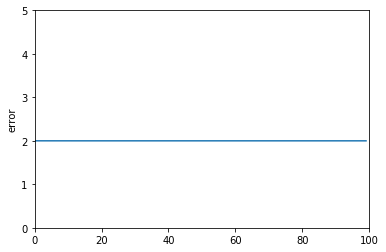

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
iterations = 100
errors = []
for i in range(0, iterations):
    act = forward(X, WEIGHTS, 'sigmoid')
    if i % 1 == 0:
        print ("it " + str(i))
        print(act[-1])
    err = compute_error(act, np.transpose(Y))
    #print ("err at iter " + str(i) + ": " + str(err))
    errors = errors + [err]
    updates = backprop(X, act, Y, WEIGHTS, 'sigmoid', .25)
    print 
    for j in range(0, len(WEIGHTS)):
        WEIGHTS[j] = WEIGHTS[j] + updates[j]

#print ("errors: " + str(errors))
plt.plot(errors)

plt.axis([0, len(errors), 0, 5])
plt.ylabel('error')
plt.show()

OK, so this solves our toy example nicely. What about some real data? Let's try mnist.

In [14]:
print('loading...')
images = np.loadtxt('c:\\users\\anthaue\\onedrive\\documents\\school\\mnist\\t10k-images-idx3-ubyte.mat')
labels = np.loadtxt('c:\\users\\anthaue\\onedrive\\documents\\school\\mnist\\t10k-labels-idx1-ubyte.mat')

loading...


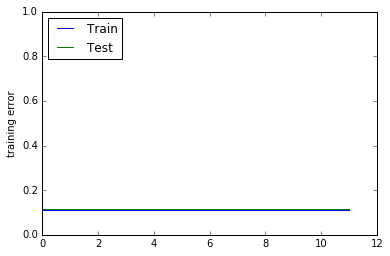

error: 70000.0
testacc: 0.11399999999999999


KeyboardInterrupt: 

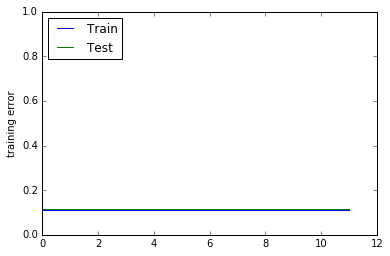

In [16]:
#The mnist labels are a single dimension, but we'd rather
#have them be a 10-dimensional array with 1 in the target dim
#and zeros elsewhere else.
import math
def vectorize_targets(x):
    ret = np.ones(([len(x), np.max(x) + 1]))
    #Try setting to -1 instead of zero for tanh learner.
    ret = ret * -1
    print (ret)
    for i in range(0, len(x)):
        ret[i][x[i]] = 1
    return ret
#Need the bias ones on the training examples
def prepend_ones_row(x):
    return np.hstack((np.ones([len(x), 1]), x))
    
#We assume symmetric around zero.
def init_random_matrix(rows, cols, magnitude):
    ret = np.random.rand(rows, cols)
    ret = ret - 0.5
    ret = ret * (2 * magnitude)
    return ret
    
def init_weights(X, Y, hiddenlen):
    #magnitude = 0.05
    (xrows, xcols) = X.shape
    (yrows, ycols) = Y.shape
    mag1 = 1 / math.sqrt(xcols)
    x2hidden = init_random_matrix(hiddenlen, xcols, mag1)
    mag2 = 1 / math.sqrt(hiddenlen)
    hidden1hidden2 = init_random_matrix(hiddenlen, hiddenlen, mag2)
    #hidden2hidden3 = init_random_matrix(hiddenlen, hiddenlen, magnitude)
    #hidden3hidden4 = init_random_matrix(hiddenlen, hiddenlen, magnitude)
    hidden2out = init_random_matrix(ycols, hiddenlen, mag2)
    #return[x2hidden, hidden1hidden2, hidden2hidden3, hidden3hidden4, hidden4out]
    return[x2hidden, hidden1hidden2, hidden2out]

def normalize_inputs(normalizeMe, minscaled, maxscaled):
    minunscaled = np.min(normalizeMe)
    maxunscaled = np.max(normalizeMe)
    ratio = (maxunscaled - minunscaled) / (maxscaled - minscaled)
    print('minunscaled ' + str(minunscaled) + ', maxunscaled ' + str(maxunscaled) + ', ratio ' + str(ratio))
    return minscaled + ((normalizeMe - minunscaled) / ratio)

def split(samples, labels, trainpercent):
    (rows, cols) = samples.shape
    allRows = np.arange(rows)
    np.random.shuffle(allRows)
    cutoffRow = rows * trainpercent
    trainIndices=allRows[0:cutoffRow]
    testIndices=allRows[cutoffRow:]
    trainSamples = samples[trainIndices]
    trainLabels = labels[trainIndices]
    testSamples = samples[testIndices]
    testLabels = labels[testIndices]
    return(trainSamples, trainLabels, testSamples, testLabels)
    
def accuracy(output, labels):
    predmax = np.argmax(output, 1)
    labmax = np.argmax(labels, 1)
    diff = predmax - labmax
    errors = np.count_nonzero(diff)
    return 1.0 - (errors / len(output))
    

print('vectorizing...')
veclabels = vectorize_targets(labels)
print(veclabels)
print('normalizing')
normalized = normalize_inputs(images, -1, 1)
print('biasing...')
biased = prepend_ones_row(normalized)
print(biased)

(trainSamples, trainLabels, testSamples, testLabels) = split(biased, veclabels, 0.7)

print('initializing weights...')
WEIGHTS = init_weights(trainSamples, trainLabels, 200)

plt.plot([], [])
plt.show()
from IPython import display

iterations = 1000
errors = []
trainAccs = []
testAccs = []
mb_size = 10
nonlinfunc = 'sigmoid'
for i in range(0, iterations):
    err=0
    #Shuffle training cases.
    order = np.arange(0, len(trainSamples))
    np.random.shuffle(order)
    trainSamples = trainSamples[order]
    trainLabels = trainLabels[order]
    for mbstart in range(0, len(trainSamples), mb_size):
        mbend = min(len(trainSamples), mbstart + mb_size)
        currX = trainSamples[mbstart:mbend,:]
        currY = trainLabels[mbstart:mbend,:]
        act = forward(currX, WEIGHTS, nonlinfunc)
        err += compute_error(act, np.transpose(currY))
        updates = backprop(currX, act, currY, WEIGHTS, nonlinfunc, 5.0)
        for j in range(0, len(WEIGHTS)):
            WEIGHTS[j] = WEIGHTS[j] + updates[j]
    errors = errors + [err]
    
    trainOut = forward(trainSamples, WEIGHTS, nonlinfunc)
    testOut = forward(testSamples, WEIGHTS, nonlinfunc)
    trainAcc = accuracy(trainOut[-1].transpose(), trainLabels)
    testAcc = accuracy(testOut[-1].transpose(), testLabels)
    trainAccs = trainAccs + [trainAcc]
    testAccs = testAccs + [testAcc]
    

#plt.plot(errors)
    rng = np.arange(len(trainAccs))
    #hl.set_xdata(rng)
    #hl.set_ydata(trainAccs)
    #hl.draw();
    plt.clf()
    plt.plot(rng, trainAccs, label='Train')
    plt.plot(rng, testAccs, label='Test')
    plt.legend(loc=2)
    plt.axis([0, len(trainAccs), 0, 1.0])
    plt.ylabel('training error')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #plt.show()
    print('error: ' + str(err))
    print('testacc: ' + str(testAcc))

